## SPEI buffering statistics
This notebook will compute the change in glacial drought buffering over time, as expressed in the difference of drought frequency and severity in SPEI$_G$ versus SPEI$_N$, comparing future time slices with an early-century baseline of 2000-2020.

9 Nov 2023 | EHU
- 19 Aug 2024: Revise read-in to use full set of 11 GCMs, with corrected basin order
- 29 Aug 2024: Create a summary figure comparable to the highlight figure in Ultee, Coats, Mackay 2022 (see `highlight_severity_fig.py`)

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
import gSPEI as gSPEI

In [2]:
## Define the filepath -- new data is streamed from Google Drive
# fpath = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/SPEI_computed/Results-scoats-20230901/'
# fpath = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/SPEI_computed/Results-scoats-20231023/'
fpath = '/Users/lizz/Desktop/SPEI-scoats-20240819/'

## Settings in filenames -- slightly different model names and scenarios
gmodels = ['GloGEM', 'PyGEM', 'OGGM']
integration_times = np.arange(3, 28, 4) # all SPEI integration times used

modelnames = ['BCC-CSM2-MR',
              'MPI-ESM1-2-HR',
              'MRI-ESM2-0',
              'CESM2-WACCM',
              'NorESM2-MM',
              'FGOALS-f3-L',
              'GFDL-ESM4',
              'INM-CM4-8',
              'INM-CM5-0',
              'EC-Earth3',
              'EC-Earth3-Veg']


scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
cases = ['NRunoff', 'WRunoff', 'diff'] # inclusion of glacier runoff

yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

In [3]:
## Basins in the order they are written
basins_all = {'RHINE':'6242', 'RHONE':'6243','PO':'6241', 'DANUBE':'6202', 'TITICACA':'3912', 'SANTA':'3425', 
            'OCONA':'3418', 'MAJES':'3416', 'MAGDALENA':'3227', 'AMAZON':'3203', 'YELCHO':'3429', 
            'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 'PASCUA':'3420', 
            'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 'BIOBIO':'3405', 'BAKER':'3404',
            'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 'NEGRO':'3232', 'COLORADO':'3212', 
            'CHICO':'3209', 'TORNEALVEN':'6255', 'THJORSA':'6254', 'OLFUSA':'6237', 'LULEALVEN':'6227', 
            'KUBAN':'6223', 'KALIXALVEN':'6219', 'GLOMAA':'6213', 'DRAMSELVA':'6209', 'SVARTA':'6110', 
            'LAGARFLJOT':'6104', 'JOKULSA A FJOLLUM':'6101', 'CLUTHA':'5406', 'YUKON':'4435', 'TAKU':'4431', 
             'SUSITNA':'4430','STIKINE':'4428', 'SKEENA':'4427','SKAGIT':'4426','NUSHAGAK':'4418','NASS':'4416',
            'KUSKOKWIM':'4414','FRASER':'4410', 'COPPER':'4408', 'COLUMBIA':'4406', 'ALSEK':'4401', 'NELSON':'4125', 
              'MACKENZIE':'4123','COLVILLE':'4110', 'YSYK-KOL':'2919', 'UVS NUUR':'2918', 'TARIM HE':'2914', 
              'TALAS':'2913', 'LAKE BALKHASH':'2910','HAR US NUUR':'2909', 'CHUY':'2905', 'ARAL SEA':'2902', 
              'YELLOW RIVER':'2434', 'MEKONG':'2421', 'KAMCHATKA':'2413', 'SALWEEN':'2319', 'IRRAWADDY':'2310', 
              'INDUS':'2309', 'GANGES':'2306','BRAHMAPUTRA':'2302', 'OB':'2108', 'INDIGIRKA':'2103','YANGTZE' : '2433'}

In [4]:
## Make an array to guarantee the order will remain intact
## Actually unnecessary - keys remember insertion order as of Python 3.7, wow modern
## 16 Aug 2024: BUT we want to confirm that the basins are the same order Sloan used, which is maybe not the case
# basin_names = basins_all.keys()

#Load in list from total Basin area data -- following Finn percent glaciation code
from scipy.io import loadmat
import pandas as pd
path_to_area = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/BasinArea.mat' ## uploaded by Sloan
BasinAreas = loadmat(path_to_area)
#Creating indices a dataframe would use
basin_areas = BasinAreas['BasinArea']
basin_names = BasinAreas['BasinNam']
basin_name_list = [name[1][0] for name in basin_names]

revised_names = {'ISSYK-KUL': 'YSYK-KOL', 'LAGARFLIOT': 'LAGARFLJOT'}.get ## revise to align Sloan's names with Finn's spelling
basin_name_list = [revised_names(n,n) for n in basin_name_list]

basin_names=basin_name_list ## just to make sure to get them all

In [5]:
itime = integration_times[0] # select timescale of integration. [0] is 3 months, used in manuscript.
scen = scenarios[1] # choose which SSP to load

## Create terrible nested dictionary until we overhaul the rest of the structure
SPEI_by_GEM = {g: {} for g in gmodels} ## outer organization by glacier model
for g in gmodels:
    SPEI_by_model = {m: {} for m in modelnames} # create dictionary indexed by model name
    for m in modelnames:
        norunoff_f_m = fpath+'NRunoff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        wrunoff_f_m = fpath+'WRunOff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        SPEI_by_model[m]['NRunoff'] = np.loadtxt(norunoff_f_m)
        SPEI_by_model[m]['WRunoff'] = np.loadtxt(wrunoff_f_m)
        SPEI_by_model[m]['diff'] = SPEI_by_model[m]['WRunoff'] - SPEI_by_model[m]['NRunoff']
    SPEI_by_GEM[g] = SPEI_by_model

In [6]:
## Inspect - looked like some NaNs, so we spot-check a few rows
sum(np.isnan(SPEI_by_GEM['GloGEM']['BCC-CSM2-MR']['NRunoff'][9]))

12

In the original `SPEI-analysis.ipynb`, we use `gSPEI.sort_models_to_basins` to organize by basin.  Here we have a different subset of basins to analyze...so we're doin' it live.

In [7]:
## revised 19 Aug 24 -- corrected basin loop to basin_name_list instead of basins_all
import pandas as pd 

SPEI_basin_sorted_GEM_raw = {g: {} for g in gmodels}
for g in gmodels:
    SPEI_by_basin = {b: {} for b in basin_name_list} # create dictionary indexed by basin name
    for i, b in enumerate(basin_name_list):
        SPEI_by_basin[b] = {case: {} for case in cases}
        for case in cases:
            tempdict = {}
            for m in modelnames:
                tempdict[m] = SPEI_by_GEM[g][m][case][i] # pull data from SPEI_by_model dicts into this new dict
            SPEI_by_basin[b][case] = pd.DataFrame.from_dict(tempdict)
    SPEI_basin_sorted_GEM_raw[g] = SPEI_by_basin

SPEI_basin_sorted_GEM = {g: {b: {} for b in basin_names} for g in gmodels}
for g in gmodels:
    for b in basin_names:
        for c in cases:
            SPEI_basin_sorted_GEM[g][b][c] = SPEI_basin_sorted_GEM_raw[g][b][c].fillna(-3) # fill negative excursions that were stored as NaNs

## Glacial drought buffering over time

Now we summarize the number and severity of droughts counted in all basins, for all GCMs, for each GEM.  We contrast the SPEI$_N$ series versus SPEI$_W$ series to isolate glacial drought buffering on each metric.

We use another helper function to identify the droughts in each series and summarize them all, storing each in a dictionary per time period such that we can see change over time.

Here we will use the early century 2000-2020 as a reference period.  We set up another layer of dictionary to include the GEM differences.

In [8]:
basin_stats_bymodel_early = {g: 
                            {m: 
                             {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2000,2020)) for b in basin_names}
                             for m in modelnames}
                            for g in gmodels} 
basin_stats_bymodel_midC = {g: 
                            {m: 
                            {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2040,2060)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}
                            
basin_stats_bymodel_endC = {g:
                            {m: {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2080,2100)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}

/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:479: RuntimeWarning: Mean of empty slice
  mean_drtdur_w = np.nanmean([np.mean(drt_dur_w_bymodel[m]) for m in modelnames])
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:481: RuntimeWarning: Mean of empty slice
  mean_drtsev_w = np.nanmean([np.mean(drt_sev_w_bymodel[m]) for m in modelnames])


In [9]:
basin_stats_bymodel_early['GloGEM'][modelnames[0]]['INDUS']

[(14.0, 15.0),
 (6.785714285714286, 6.666666666666667),
 (-7.154211286214286, -7.5489181540666666)]

In [10]:
basin_stats_bymodel_midC['GloGEM'][modelnames[0]]['INDUS']

[(16.0, 18.0),
 (6.1875, 6.611111111111111),
 (-7.2350768066875, -7.493108738611111)]

In [11]:
basin_stats_bymodel_endC['GloGEM'][modelnames[0]]['INDUS']

[(21.0, 20.0),
 (5.761904761904762, 7.0),
 (-7.077195155809524, -8.141801516249998)]

Okay, we can see some changes in buffering over time, as might be expected.  Looks okay.  Not directly comparable to our previous results because these are 20-year periods instead of 30-year...but we can compare the glacier evolution models to each other.  Let's make a new version of the $\Delta$ frequency and severity plots we made for the previous manuscript.  The below is pasted from `SPEI_analysis.ipynb`, with modifications to account for the more complicated structure of updated `basin_stats_bymodel` dictionaries.

### Direct comparison of the three GEMs
We've made some single-GEM plots to see change in drought buffering over time.  Now, can we compare the single-GEM results directly?

Perhaps let's select just the end of the century and show it with all three GEMs, with their change compared to their own early-century baseline?  This will be similar in format to the highlight figure produced for ESD (`highlight_severity_fig.py`).

Hmm, this is not very pretty.  Can we make bars comparing the three single-GEM, multi-GCM mean results instead?

In [12]:
## bring in Finn's initial volume list
## this is for GloGEM for SSP245 for now
volume_file = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/Mean_Initial_Volumes_ssp245.csv'

initial_vols = pd.read_csv(volume_file, index_col=0) ## Lolol just read this in

In [13]:
initial_vols.loc['YUKON', 'GloGEM']

1948.3885153846152

Read in percent glacier cover from Finn's summary stats.  Yay! Using just GloGEM baseline for now; these shouldn't vary much by GEM anyway.

In [14]:
## bring in Finn's basin summary stats
## this is for GloGEM for SSP245 for now
summary_file = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/MASTER_GloGEM.csv'

percent_glaciated = pd.read_csv(summary_file, index_col=0).loc[:, 'GlacierAreaFrac'] ## Lolol just read this in instead of fixing up the copypasta below

In [15]:
percent_glaciated.loc['YUKON']

0.0120027953168836

Make a panel like the highlight fig from Ultee et al 2022.  Edit 29 Oct 2024: display change marker only if increase or decrease is a percentage of the original signal (not a static 0.1 threshold)?

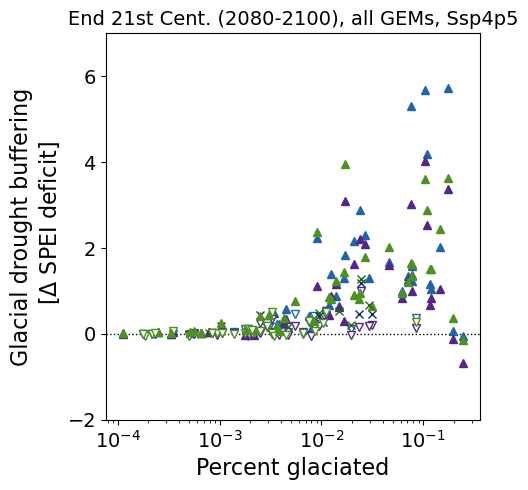

In [60]:
## Color defaults per model
colorcode = ['RdBu', 'PuOr', 'PiYG']
counter_increase = []
counter_decrease = []
counter_nochange = []

## Create figure with only the end-century severity panel
fig, ax = plt.subplots(figsize=(5,5))

for this_GEM, c in zip(gmodels, colorcode):
    
    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(1.0)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)
        
    for j, b in enumerate(basin_names):
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []
        
        # vol = initial_vols.loc[b,test_GEM]
        pg = percent_glaciated.loc[b]

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[this_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[this_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[this_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[this_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[this_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[this_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[this_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[this_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[this_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[this_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[this_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[this_GEM][m][b][2][0]))

        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        # if endC_v_hist_s >0.1:
        if endC_v_hist_s > (0.1*np.nanmean(severity_b)): ## 10% change in original signal
            # endC_color_s=inc_color
            end_facecolor = inc_color
            end_edgecolor = inc_color
            endC_marker_s='^'
            counter_increase.append(this_GEM+'-'+b)
        # elif endC_v_hist_s<-0.1:
        elif endC_v_hist_s < (-0.1*np.nanmean(severity_b)):
            # endC_color_s=dec_color
            # end_facecolor = dec_color
            # end_edgecolor = dec_color
            end_facecolor = 'white'
            end_edgecolor = inc_color
            endC_marker_s='v'
            counter_decrease.append(this_GEM+'-'+b)
        else:
            # endC_color_s='k'
            end_facecolor = 'white'
            end_edgecolor = base_color
            endC_marker_s='x'
            counter_nochange.append(this_GEM+'-'+b)
        ax.errorbar(pg, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     marker=endC_marker_s, mec = end_edgecolor, mfc=end_facecolor,
                    ecolor=end_edgecolor, lw=1.0,
                   elinewidth=0)


ax.set_ylabel(r'Glacial drought buffering'
              '\n'
              ' [$\Delta$ SPEI deficit]',fontsize=16) 
ax.set(xscale='log', ylim=(-2,7))
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_xlabel('Percent glaciated', fontsize=16)
ax.set_title('End 21st Cent. (2080-2100), all GEMs, {}'.format(scen), fontsize=14)
ax.tick_params(which='both', labelsize=14)
ax.axhline(0, ls=':', lw=1.0, color='k')
plt.tight_layout()

Plot just the *change* in severity buffering?

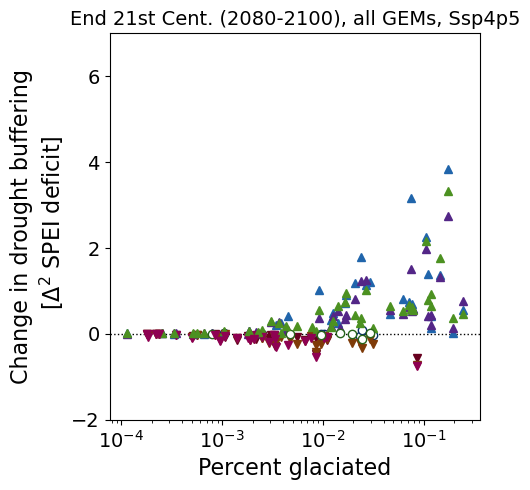

In [43]:
## Color defaults per model
colorcode = ['RdBu', 'PuOr', 'PiYG']
counter_increase = []
counter_decrease = []
counter_nochange = []

## Create figure with only the end-century severity panel
fig, ax = plt.subplots(figsize=(5,5))

for this_GEM, c in zip(gmodels, colorcode):
    
    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(1.0)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)
        
    for j, b in enumerate(basin_names):
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []
        
        # vol = initial_vols.loc[b,test_GEM]
        pg = percent_glaciated.loc[b]

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[this_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[this_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[this_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[this_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[this_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[this_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[this_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[this_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[this_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[this_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[this_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[this_GEM][m][b][2][0]))

        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        # if endC_v_hist_s >0.1:
        if endC_v_hist_s > (0.1*np.nanmean(severity_b)): ## 10% change in original signal
            # endC_color_s=inc_color
            end_facecolor = inc_color
            end_edgecolor = inc_color
            endC_marker_s='^'
            counter_increase.append(this_GEM+'-'+b)
        # elif endC_v_hist_s<-0.1:
        elif endC_v_hist_s < (-0.1*np.nanmean(severity_b)):
            # endC_color_s=dec_color
            end_facecolor = dec_color
            end_edgecolor = dec_color
            endC_marker_s='v'
            counter_decrease.append(this_GEM+'-'+b)
        else:
            # endC_color_s='k'
            end_facecolor = 'white'
            end_edgecolor = base_color
            endC_marker_s='o'
            counter_nochange.append(this_GEM+'-'+b)
        ax.errorbar(pg, np.nanmean(endC_v_hist_s), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     marker=endC_marker_s, mec = end_edgecolor, mfc=end_facecolor,
                    ecolor=end_edgecolor, lw=1.0,
                   elinewidth=0)


ax.set_ylabel(r'Change in drought buffering'
              '\n'
              ' [$\Delta^2$ SPEI deficit]',fontsize=16) 
ax.set(xscale='log', ylim=(-2,7))
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_xlabel('Percent glaciated', fontsize=16)
ax.set_title('End 21st Cent. (2080-2100), all GEMs, {}'.format(scen), fontsize=14)
ax.tick_params(which='both', labelsize=14)
ax.axhline(0, ls=':', lw=1.0, color='k')
plt.tight_layout()

Plot both together, stacked two panels.

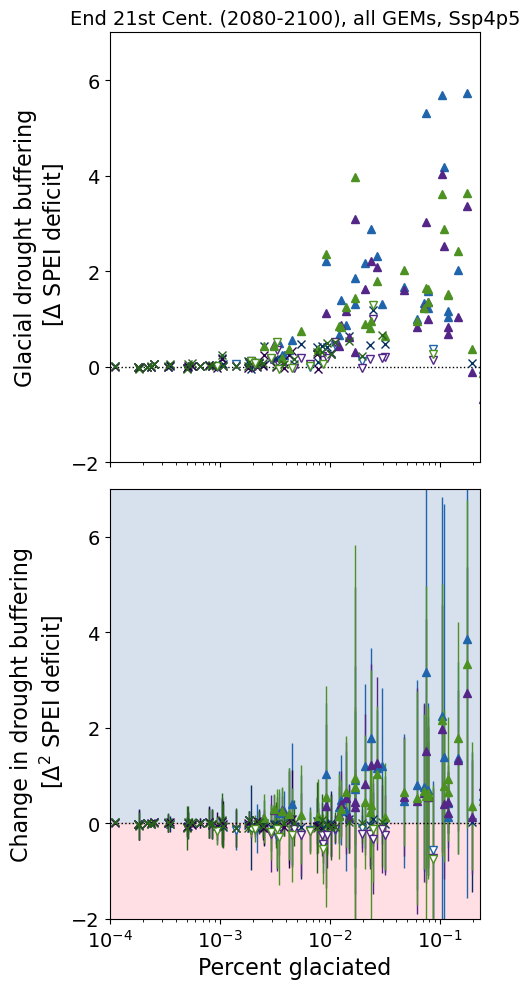

In [67]:
counter_increase = []
counter_decrease = []
counter_nochange = []

from matplotlib import patches 
fig, axs = plt.subplots(2,1, figsize=(5,10), sharex=True, sharey=True)

r_pos = patches.Rectangle((0,0), width=1, height=8, color='lightsteelblue', alpha=0.5)
r_neg = patches.Rectangle((0,0), width=1, height=-3, color='pink', alpha=0.5)
axs[1].add_patch(r_pos) ## shade increased-buffering region of plot
axs[1].add_patch(r_neg) ## shade decreased-buffering region of plot

for this_GEM, c in zip(gmodels, colorcode):
    
    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(1.0)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)
        
    for j, b in enumerate(basin_names):
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []
        
        # vol = initial_vols.loc[b,test_GEM]
        pg = percent_glaciated.loc[b]

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[this_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[this_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[this_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[this_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[this_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[this_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[this_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[this_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[this_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[this_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[this_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[this_GEM][m][b][2][0]))

        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        if endC_v_hist_s >0.1:
            end_facecolor = inc_color
            end_edgecolor = inc_color
            endC_marker_s='^'
            counter_increase.append(this_GEM+'-'+b)
        elif endC_v_hist_s<-0.1:
            # end_facecolor = dec_color
            # end_edgecolor = dec_color
            end_facecolor = 'white'
            end_edgecolor = inc_color
            endC_marker_s='v'
            counter_decrease.append(this_GEM+'-'+b)
        else:
            # endC_color_s='k'
            end_facecolor = 'white'
            end_edgecolor = base_color
            endC_marker_s='x'
            counter_nochange.append(this_GEM+'-'+b)
        axs[0].errorbar(pg, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     marker=endC_marker_s, mec = end_edgecolor, mfc=end_facecolor,
                    ecolor=end_edgecolor, lw=1.0,
                   elinewidth=0)
        
        axs[1].errorbar(pg, np.nanmean(endC_v_hist_s), 
             yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
             marker=endC_marker_s, mec = end_edgecolor, mfc=end_facecolor,
            ecolor=end_edgecolor, lw=1.0)


axs[0].set_ylabel(r'Glacial drought buffering'
              '\n'
              ' [$\Delta$ SPEI deficit]',fontsize=16)
axs[1].set_ylabel(r'Change in drought buffering'
              '\n'
              ' [$\Delta^2$ SPEI deficit]',fontsize=16)
axs[0].set(xscale='log', xlim=(1E-4, 0.23), ylim=(-2,7))
axs[0].set_yticks([-2, 0, 2, 4, 6])
axs[1].set_xlabel('Percent glaciated', fontsize=16)
axs[0].set_title('End 21st Cent. (2080-2100), all GEMs, {}'.format(scen), fontsize=14)
for ax in axs:
    ax.tick_params(which='both', labelsize=14)
    ax.axhline(0, ls=':', lw=1.0, color='k')
plt.tight_layout()

In [73]:
len([c for c in counter_increase if 'GloGEM' in c])

28

Note 30 Oct: we used the above cell to produce counts of the number of increased, decreased, and no-change basin-model pairs.  The code below is legacy, used to compare directly with our 2022 paper on a per-GEM basis.  Consider removing.

---

### Plot change over time for all three models, with percent glaciation on the x-axis now.

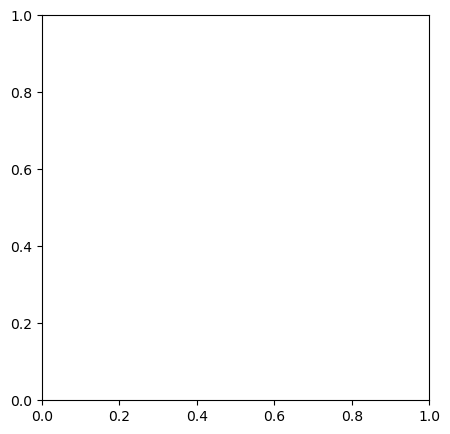

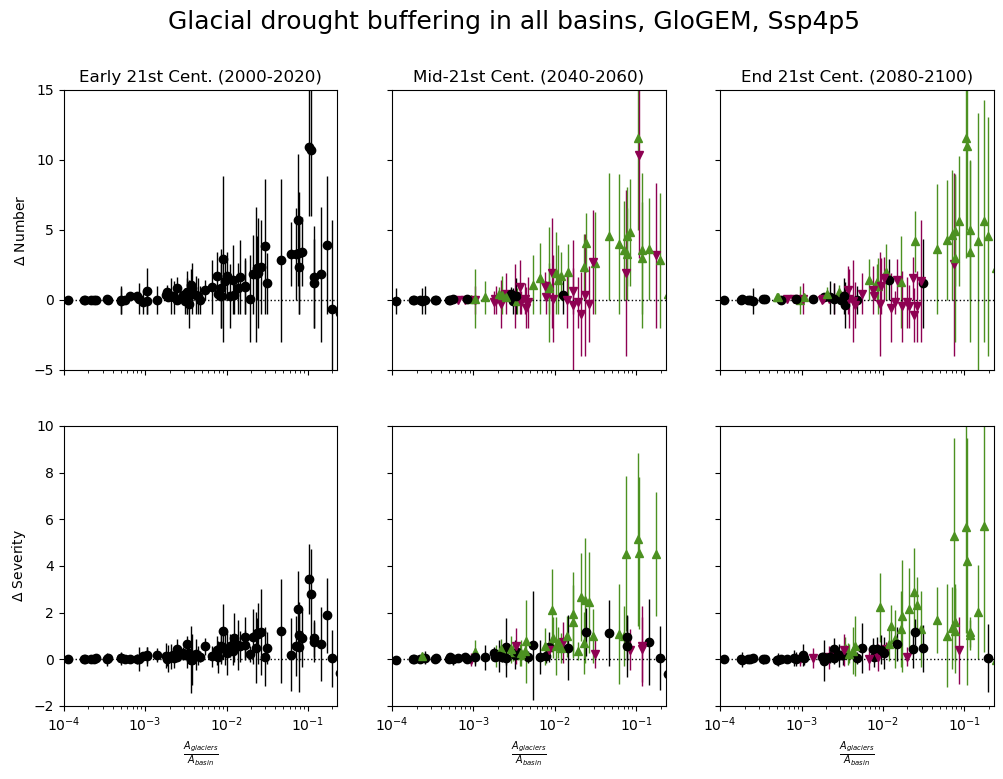

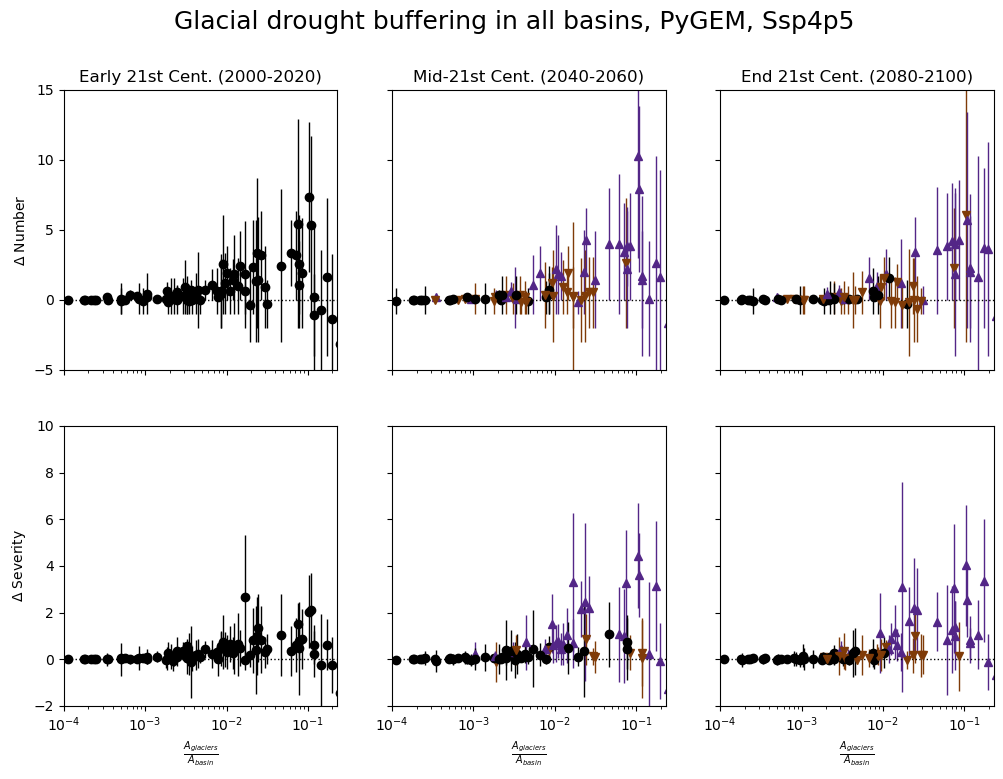

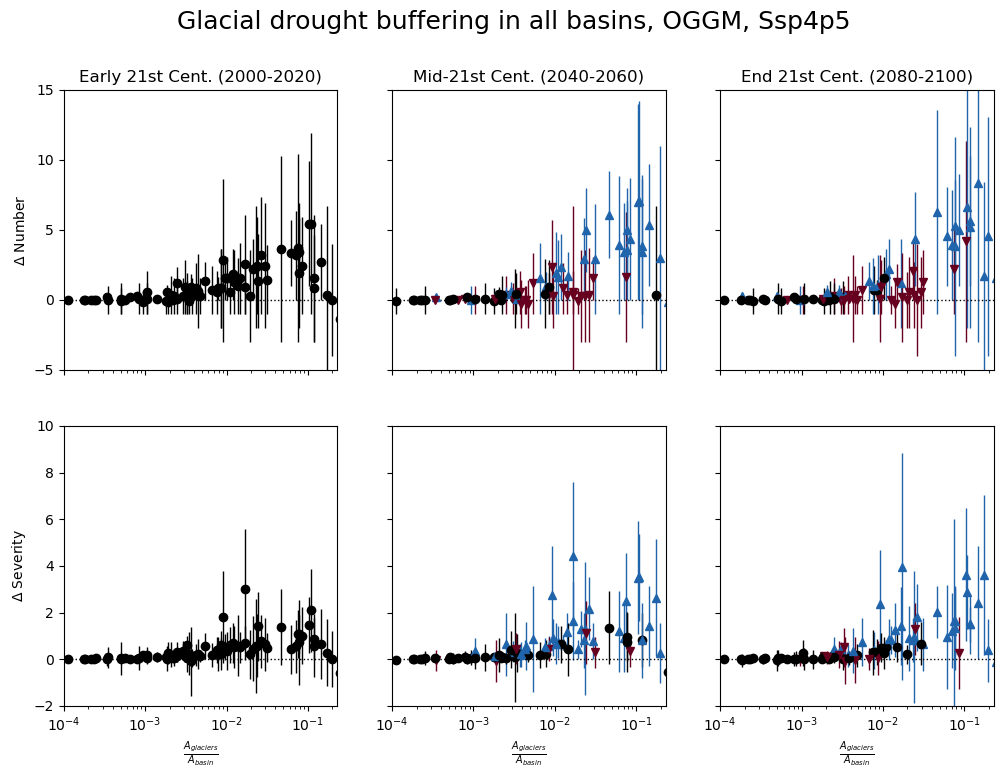

In [26]:
# ## Composite of all stats over time
# color_fam = cm.get_cmap('tab20b')
# inc_color=color_fam(5)
# dec_color=color_fam(17)

# test_GEM = 'GloGEM'

## Color defaults per model
colorcode = [ 'PiYG', 'PuOr', 'RdBu']

## Create figure with the comparison over time
fig, ax = plt.subplots(figsize=(5,5))

for test_GEM, c in zip(gmodels, colorcode):
    
    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(1.0)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)

    fig3, ((ax1,ax2, ax3), 
           (ax7,ax8,ax9)) = plt.subplots(2,3, sharex=True, sharey='row', figsize=(12,8))
    for j, b in enumerate(basin_names):
        pg = percent_glaciated.loc[b]
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[test_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[test_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[test_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[test_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[test_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[test_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[test_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[test_GEM][m][b][2][0]))

        ## Color code changes over time
        midC_v_hist_n = np.nanmean(number_midC)-np.nanmean(number_b)
        if midC_v_hist_n >0.1: # buffering on number increasing
            midC_color_n=inc_color
            midC_marker_n='^'
        elif midC_v_hist_n<-0.1:
            midC_color_n=dec_color
            midC_marker_n='v'
        else:
            midC_color_n='k'
            midC_marker_n='o'
        endC_v_hist_n = np.nanmean(number_endC)-np.nanmean(number_b)
        if endC_v_hist_n >0.1:
            endC_color_n=inc_color
            endC_marker_n='^'
        elif endC_v_hist_n<-0.1:
            endC_color_n=dec_color
            endC_marker_n='v'
        else:
            endC_color_n='k'
            endC_marker_n='o'

        midC_v_hist_s = np.nanmean(severity_midC)-np.nanmean(severity_b)
        if midC_v_hist_s >0.1: # buffering on duration increasing
            midC_color_s=inc_color
            midC_marker_s='^'
        elif midC_v_hist_s<-0.1:
            midC_color_s=dec_color
            midC_marker_s='v'
        else:
            midC_color_s='k'
            midC_marker_s='o'
        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        if endC_v_hist_s >0.1:
            endC_color_s=inc_color
            endC_marker_s='^'
        elif endC_v_hist_s<-0.1:
            endC_color_s=dec_color
            endC_marker_s='v'
        else:
            endC_color_s='k'
            endC_marker_s='o'
        ## First column: historical
        ax1.errorbar(pg, np.nanmean(number_b), 
                     yerr=np.asarray(np.nanmean(number_b)-np.nanmin(number_b), np.nanmax(number_b)-np.nanmean(number_b)).transpose(), 
                     color='k', marker='o', lw=1.0)
        ax7.errorbar(pg, np.nanmean(severity_b), 
                     yerr=np.asarray(np.nanmean(severity_b)-np.nanmin(severity_b), np.nanmax(severity_b)-np.nanmean(severity_b)).transpose(), 
                     color='k', marker='o', lw=1.0)
        ## Second column: mid-c
        ax2.errorbar(pg, np.nanmean(number_midC), 
                     yerr=np.asarray(np.nanmean(number_midC)-np.nanmin(number_midC), np.nanmax(number_midC)-np.nanmean(number_midC)).transpose(), 
                     color=midC_color_n, marker=midC_marker_n, lw=1.0)
        ax8.errorbar(pg, np.nanmean(severity_midC), 
                     yerr=np.asarray(np.nanmean(severity_midC)-np.nanmin(severity_midC), np.nanmax(severity_midC)-np.nanmean(severity_midC)).transpose(), 
                     color=midC_color_s, marker=midC_marker_s, lw=1.0)
        ## Third column: end of century
        ax3.errorbar(pg, np.nanmean(number_endC), 
                     yerr=np.asarray(np.nanmean(number_endC)-np.nanmin(number_endC), np.nanmax(number_endC)-np.nanmean(number_endC)).transpose(), 
                     color=endC_color_n, marker=endC_marker_n, lw=1.0)
        ax9.errorbar(pg, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     color=endC_color_s, marker=endC_marker_s, lw=1.0)

    ax1.set(ylabel=r'$\Delta$ Number', title='Early 21st Cent. (2000-2020)',
           ylim=(-5,15), yticks=(-5, 0, 5, 10,15))
    ax2.set(title='Mid-21st Cent. (2040-2060)')
    ax3.set(title='End 21st Cent. (2080-2100)')
    ax7.set(ylabel=r'$\Delta$ Severity', 
            xlabel=r'$\frac{A_{glaciers}}{A_{basin}}$',
           ylim=(-2,10), yticks=(-2, 0, 2, 4, 6, 8, 10))
    ax8.set(xlabel=r'$\frac{A_{glaciers}}{A_{basin}}$')
    ax9.set(xlabel=r'$\frac{A_{glaciers}}{A_{basin}}$')
    for ax in (ax1,ax2,ax3,
               ax7,ax8,ax9):
        ax.axhline(0, ls=':', lw=1.0, color='k')
        ax.set(xscale='log', xlim=(1E-4, 0.23))
    fig3.suptitle('Glacial drought buffering in all basins, {}, {}'.format(test_GEM, scen), fontsize=18)
    plt.savefig('/Users/Lizz/Desktop/{}-drought_buffering_timeslices-{}_{}'.format(datetime.date.today(), test_GEM, scen))

These are not directly comparable to our ESD results because the historical "baseline" time period is different.  Let's plot just GloGEM with results for the same periods as the ESD example, if possible.

- Note 19 August: Not directly comparable, but with correct basin read-in order, actually these results are broadly similar to previous results in our ESD paper.  This suggests that our ESD results are somewhat robust to choice of baseline as well as to GCM and GEM.

In [27]:
basin_stats_GloGEM_hist = {m: 
                             {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['GloGEM'], basin_name=b, modelnames=[m], period=(1980,2010)) for b in basin_names}
                             for m in modelnames}
basin_stats_GloGEM_midC = {m: 
                            {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['GloGEM'], basin_name=b, modelnames=[m], period=(2030,2060)) for b in basin_names} 
                             for m in modelnames}
                            
basin_stats_GloGEM_endC = {m: {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['GloGEM'], basin_name=b, modelnames=[m], period=(2070,2100)) for b in basin_names} 
                             for m in modelnames}

/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:479: RuntimeWarning: Mean of empty slice
  mean_drtdur_w = np.nanmean([np.mean(drt_dur_w_bymodel[m]) for m in modelnames])
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:481: RuntimeWarning: Mean of empty slice
  mean_drtsev_w = np.nanmean([np.mean(drt_sev_w_bymodel[m]) for m in modelnames])


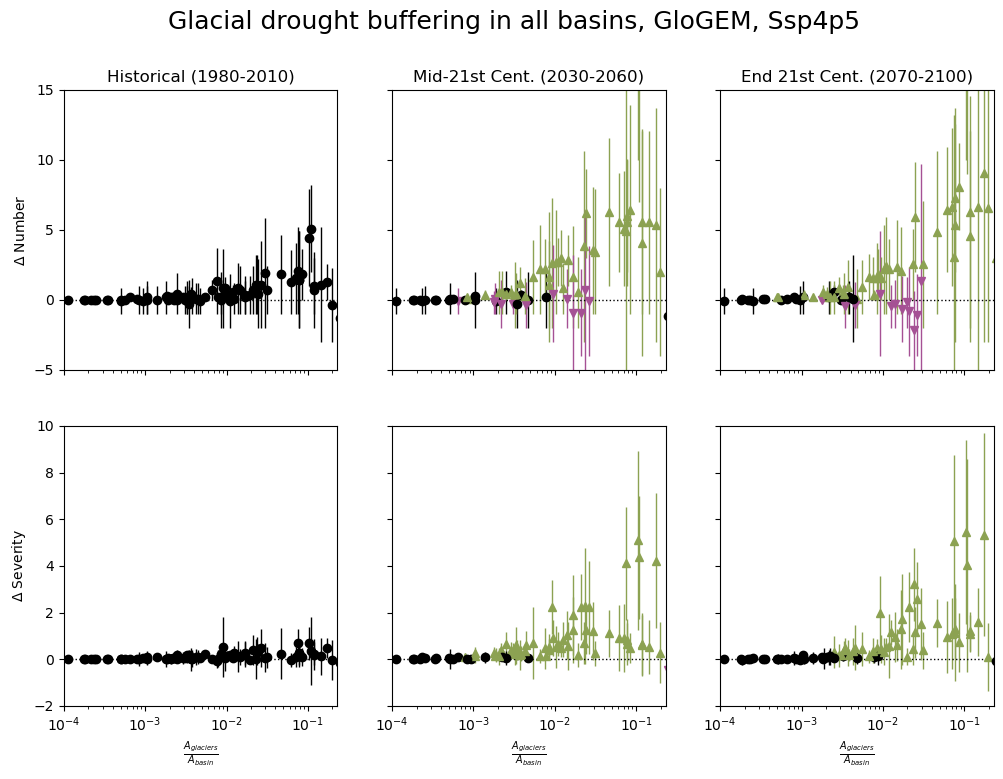

In [28]:
# ## Composite of all stats over time
color_fam = cm.get_cmap('tab20b')
inc_color=color_fam(5)
dec_color=color_fam(17)

test_GEM = 'GloGEM'

# ## Color defaults per model
# colorcode = [ 'PiYG', 'PuOr', 'RdBu']

## Create figure with the comparison over time -- same time periods as ESD paper

fig3, ((ax1,ax2, ax3), 
       (ax7,ax8,ax9)) = plt.subplots(2,3, sharex=True, sharey='row', figsize=(12,8))
for j, b in enumerate(basin_names):
    pg = percent_glaciated.loc[b]
    number_b = []
    severity_b = []
    number_midC = []
    number_endC = []
    severity_midC = []
    severity_endC = []

    for m in modelnames:
        number_b.append(basin_stats_GloGEM_hist[m][b][0][1]
                        -basin_stats_GloGEM_hist[m][b][0][0])
        number_midC.append(basin_stats_GloGEM_midC[m][b][0][1]
                           -basin_stats_GloGEM_midC[m][b][0][0])
        number_endC.append(basin_stats_GloGEM_endC[m][b][0][1]
                           -basin_stats_GloGEM_endC[m][b][0][0])
        severity_b.append(-1*(basin_stats_GloGEM_hist[m][b][2][1]
                              -basin_stats_GloGEM_hist[m][b][2][0]))
        severity_midC.append(-1*(basin_stats_GloGEM_midC[m][b][2][1]
                                 -basin_stats_GloGEM_midC[m][b][2][0]))
        severity_endC.append(-1*(basin_stats_GloGEM_endC[m][b][2][1]
                                 -basin_stats_GloGEM_endC[m][b][2][0]))

    ## Color code changes over time
    midC_v_hist_n = np.nanmean(number_midC)-np.nanmean(number_b)
    if midC_v_hist_n >0.1: # buffering on number increasing
        midC_color_n=inc_color
        midC_marker_n='^'
    elif midC_v_hist_n<-0.1:
        midC_color_n=dec_color
        midC_marker_n='v'
    else:
        midC_color_n='k'
        midC_marker_n='o'
    endC_v_hist_n = np.nanmean(number_endC)-np.nanmean(number_b)
    if endC_v_hist_n >0.1:
        endC_color_n=inc_color
        endC_marker_n='^'
    elif endC_v_hist_n<-0.1:
        endC_color_n=dec_color
        endC_marker_n='v'
    else:
        endC_color_n='k'
        endC_marker_n='o'

    midC_v_hist_s = np.nanmean(severity_midC)-np.nanmean(severity_b)
    if midC_v_hist_s >0.1: # buffering on duration increasing
        midC_color_s=inc_color
        midC_marker_s='^'
    elif midC_v_hist_s<-0.1:
        midC_color_s=dec_color
        midC_marker_s='v'
    else:
        midC_color_s='k'
        midC_marker_s='o'
    endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
    if endC_v_hist_s >0.1:
        endC_color_s=inc_color
        endC_marker_s='^'
    elif endC_v_hist_s<-0.1:
        endC_color_s=dec_color
        endC_marker_s='v'
    else:
        endC_color_s='k'
        endC_marker_s='o'
    ## First column: historical
    ax1.errorbar(pg, np.nanmean(number_b), 
                 yerr=np.asarray(np.nanmean(number_b)-np.nanmin(number_b), np.nanmax(number_b)-np.nanmean(number_b)).transpose(), 
                 color='k', marker='o', lw=1.0)
    ax7.errorbar(pg, np.nanmean(severity_b), 
                 yerr=np.asarray(np.nanmean(severity_b)-np.nanmin(severity_b), np.nanmax(severity_b)-np.nanmean(severity_b)).transpose(), 
                 color='k', marker='o', lw=1.0)
    ## Second column: mid-c
    ax2.errorbar(pg, np.nanmean(number_midC), 
                 yerr=np.asarray(np.nanmean(number_midC)-np.nanmin(number_midC), np.nanmax(number_midC)-np.nanmean(number_midC)).transpose(), 
                 color=midC_color_n, marker=midC_marker_n, lw=1.0)
    ax8.errorbar(pg, np.nanmean(severity_midC), 
                 yerr=np.asarray(np.nanmean(severity_midC)-np.nanmin(severity_midC), np.nanmax(severity_midC)-np.nanmean(severity_midC)).transpose(), 
                 color=midC_color_s, marker=midC_marker_s, lw=1.0)
    ## Third column: end of century
    ax3.errorbar(pg, np.nanmean(number_endC), 
                 yerr=np.asarray(np.nanmean(number_endC)-np.nanmin(number_endC), np.nanmax(number_endC)-np.nanmean(number_endC)).transpose(), 
                 color=endC_color_n, marker=endC_marker_n, lw=1.0)
    ax9.errorbar(pg, np.nanmean(severity_endC), 
                 yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                 color=endC_color_s, marker=endC_marker_s, lw=1.0)

ax1.set(ylabel=r'$\Delta$ Number', title='Historical (1980-2010)',
       ylim=(-5,15), yticks=(-5, 0, 5, 10,15))
ax2.set(title='Mid-21st Cent. (2030-2060)')
ax3.set(title='End 21st Cent. (2070-2100)')
ax7.set(ylabel=r'$\Delta$ Severity', 
        xlabel=r'$\frac{A_{glaciers}}{A_{basin}}$',
       ylim=(-2,10), yticks=(-2, 0, 2, 4, 6, 8, 10))
ax8.set(xlabel=r'$\frac{A_{glaciers}}{A_{basin}}$')
ax9.set(xlabel=r'$\frac{A_{glaciers}}{A_{basin}}$')
for ax in (ax1,ax2,ax3,
           ax7,ax8,ax9):
    ax.axhline(0, ls=':', lw=1.0, color='k')
    ax.set(xscale='log', xlim=(1E-4, 0.23))
fig3.suptitle('Glacial drought buffering in all basins, {}, {}'.format(test_GEM, scen), fontsize=18)
plt.savefig('/Users/Lizz/Desktop/{}-drought_buffering_timeslices-ESD_periods-{}_{}'.format(datetime.date.today(), test_GEM, scen))

Slightly different.  This is probably down to the CMIP5->6 forcing.